# Basic regression: Predict Action

In a *regression* problem, we aim to predict the output of a continuous value, which is in this case the Actions

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint

In [24]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [25]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First Import it using pandas

In [26]:

raw_dataset = pd.read_csv("./test.csv")

dataset = raw_dataset.copy()


We need all the path to have the same steps. Therefore we will trunk the path to the same lenght and omit those with reduced lenght

First we check with is the most common lenght

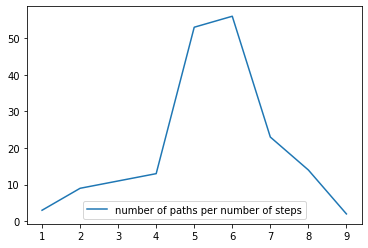

In [5]:
len_stat = dataset.groupby(["id_camino"]).size().reset_index(name='counts')
plt.plot(len_stat.groupby(["counts"]).size(), label ="number of paths per number of steps")
plt.legend()

We will cut at 4 steps (n=5) and remove the path with less than 4 steps

In [27]:
long_paths = len_stat[len_stat.counts>4]
red_dataset = dataset.loc[dataset["id_camino"].isin(long_paths["id_camino"])]
reg_dataset= red_dataset[red_dataset.id_in_seq<5] 
reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581


Finaly, the new goal state is the last state of each path
goal state = Path[4] 

In [28]:
for id in reg_dataset["id_camino"]:
     dummy = "a"
     dummy = reg_dataset.loc[(reg_dataset["id_camino"] == id) & (reg_dataset["id_in_seq"] == 4)].current_state
     for index in reg_dataset[reg_dataset["id_camino"] == id]:
         reg_dataset["goal_state"][index] = dummy

reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581


In [8]:
reg_dataset["goal_state"]

20               [3355.2520452554118, -366.8261847192736, 1.151...
21               [3355.2520452554118, -366.8261847192736, 1.151...
22               [3355.2520452554118, -366.8261847192736, 1.151...
23               [3355.2520452554118, -366.8261847192736, 1.151...
24               [3355.2520452554118, -366.8261847192736, 1.151...
                                       ...                        
id_in_seq        996    [2145.6242327499517, -258.8787869368321...
current_state    996    [2145.6242327499517, -258.8787869368321...
goal_state       996    [2145.6242327499517, -258.8787869368321...
out_action       996    [2145.6242327499517, -258.8787869368321...
timesteps        996    [2145.6242327499517, -258.8787869368321...
Name: goal_state, Length: 746, dtype: object

In [29]:

dataset = reg_dataset

for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["out_action"][index] = int(dataset["out_action"][index])

dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


In [30]:
dataset[0:10]

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps,Difference,C0,C1,C2,C3,C4,C5,D0,D1,D2,D3,D4,D5
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[3355.2520452554118, -366.8261847192736, 0.151...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3355.252045,-366.826185,0.151482,0.183113,0.052711,-0.001145
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[2797.9646834186974, -278.47214054348416, -0.7...",557.287362,-88.354044,1.904406,0.117667,-0.007043,0.001597,2797.964683,-278.472141,-0.752924,0.065446,0.059754,-0.002742
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[2240.255731387366, -218.07119735157323, -0.64...",1114.996314,-148.754987,1.794546,0.119579,-0.059903,0.000014,2240.255731,-218.071197,-0.643064,0.063534,0.112614,-0.001159
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[1678.402120847001, -153.905453780367, -0.6384...",1676.849924,-212.920731,1.789949,0.119717,-0.045089,-0.000059,1678.402121,-153.905454,-0.638468,0.063397,0.097800,-0.001086
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581,"[1117.6644822084872, -89.83383344236347, -0.64...",2237.587563,-276.992351,1.794838,0.119611,-0.047056,0.000015,1117.664482,-89.833833,-0.643357,0.063503,0.099767,-0.001159
27,9,0,"[0, 0, 1, 0, 0, 0]","[2907.0542848353966, -263.57882736991, 1.16306...",3,315.345581,"[2907.0542848353966, -263.57882736991, 0.16306...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2907.054285,-263.578827,0.163066,0.182490,0.065083,-0.000678
28,9,1,"[467.51084210168455, -52.85735936140974, 1.396...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[2439.5434427337123, -210.72146800850027, -0.2...",467.510842,-52.857359,1.396266,0.147218,0.014904,-0.002213,2439.543443,-210.721468,-0.233200,0.035272,0.050179,0.001535
29,9,2,"[881.3909271559311, -87.82787195861813, 1.3092...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[2025.6633576794657, -175.7509554112919, -0.14...",881.390927,-87.827872,1.309273,0.164303,0.046378,0.000011,2025.663358,-175.750955,-0.146207,0.018187,0.018705,-0.000689
30,9,3,"[1293.8754807566058, -124.08675633965926, 1.30...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[1613.1788040787908, -139.49207103025077, -0.1...",1293.875481,-124.086756,1.306958,0.164448,0.036881,-0.000074,1613.178804,-139.492071,-0.143892,0.018042,0.028202,-0.000604
31,9,4,"[1706.6741019079343, -160.4873748066237, 1.309...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[1200.3801829274623, -103.09145256328631, -0.1...",1706.674102,-160.487375,1.309686,0.164356,0.036761,0.000006,1200.380183,-103.091453,-0.146620,0.018134,0.028322,-0.000683


### Clean the data


check if the data contains unknown values.

In [10]:
dataset.isna().sum()

id_camino        0
id_in_seq        0
current_state    0
goal_state       0
out_action       0
timesteps        0
Difference       0
C0               0
C1               0
C2               0
C3               0
C4               0
C5               0
D0               0
D1               0
D2               0
D3               0
D4               0
D5               0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [11]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [12]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [31]:
train_labels = train_dataset[["out_action"]]
test_labels = test_dataset[["out_action"]]

normed_train_data  = train_dataset[["D0",'D1',"D2","D3",'D4',"D5"]]
normed_test_data = test_dataset[["D0",'D1',"D2","D3",'D4',"D5"]]


It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [32]:
train_labels

,out_action
303,3
290,2
40,5
68,2
921,1
...,...
60,2
175,2
221,4
225,1


In [33]:
BATCH_SIZE = 5
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((normed_train_data, train_labels))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((normed_test_data, test_labels))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [24]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [26]:
example_batch = normed_train_data[:10][0:8]
example_result = model.predict(example_batch)
example_result

array([[-200.36516 ,  -87.40591 ,  172.07886 ],
       [-423.4718  , -200.24365 ,  379.01324 ],
       [ -51.97265 ,  -27.54663 ,   50.85124 ],
       [-398.12457 , -160.00687 ,  328.2099  ],
       [-236.4733  ,  -89.440384,  190.69928 ],
       [-321.8714  , -127.116714,  263.1602  ],
       [-642.5829  , -237.1669  ,  513.9866  ],
       [-264.5927  , -116.401474,  227.9678  ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [27]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:21633.8994,  mae:85.1138,  mse:21633.9004,  val_loss:15938.0527,  val_mae:74.6532,  val_mse:15938.0537,  
....................................................................................................
Epoch: 100, loss:12394.3369,  mae:55.2535,  mse:12394.3379,  val_loss:12358.5990,  val_mae:54.0840,  val_mse:12358.5996,  
....................................................................................................
Epoch: 200, loss:8122.0882,  mae:42.8626,  mse:8122.0879,  val_loss:6567.0997,  val_mae:36.9362,  val_mse:6567.0996,  
....................................................................................................
Epoch: 300, loss:5521.2418,  mae:34.8475,  mse:5521.2422,  val_loss:4133.7958,  val_mae:30.8988,  val_mse:4133.7959,  
....................................................................................................
Epoch: 400, loss:4983.5381,  mae:33.3873,  mse:4983.5376,  val_loss:4856.4337,  val_mae:34.3563,  val_mse:4856.43

Visualize the model's training progress using the stats stored in the `history` object.

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3521.557295,28.668604,3521.557373,2902.070484,26.230659,2902.070557,995
996,2580.274309,24.599665,2580.274414,9061.028690,46.254494,9061.028320,996
997,3831.562825,29.740545,3831.562988,2535.207190,25.491159,2535.207275,997
998,2832.734515,25.660353,2832.734375,4470.236849,32.297901,4470.236816,998
999,3245.237105,27.657951,3245.237061,2338.469087,25.209881,2338.469238,999


In [34]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Action]')

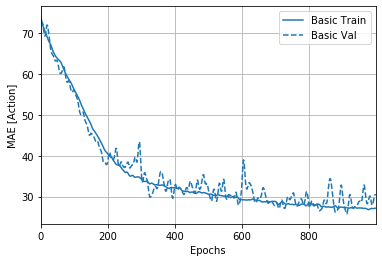

In [36]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Action]')

In [1]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE')

NameError: name 'plotter' is not defined

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [67]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:553.0348,  mae:22.2684,  mse:553.0349,  val_loss:536.8481,  val_mae:21.8744,  val_mse:536.8481,  
.............................................

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Action".format(mae))

### Make predictions

Finally, predict MPG values using data in the testing set:

In [1]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Action]')
plt.ylabel('Predictions [Action]')
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


NameError: name 'model' is not defined

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Action]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.